# ML no supervisado: Clusters jerárquicos de laboratorios clínicos y efectos adversos

Puede ver una introducción a este algoritmo en https://www.ibm.com/think/topics/hierarchical-clustering

Veamos si existe algun tipo de correlación entre las variables de laboratorios clínicos y también entre los efectos adversos; uno de los métodos más efectivos y visualmente fáciles de entender es el clustering aglomerativo jerárquico, la librería de scipy.cluster nos permite realizar esta tarea. Lo fundamental resulta generar la **matriz de distancias** que la función **linkage** utiliza para hacer la agrupación de las variables.

¿Cómo se obtiene esa matriz de distancias?
1. Primero Necesito un tipo de medida, en este caso utilizaremos la correlación de spearman para medir relaciones monotónicas de variables
2. Con la matriz de correlacion de Spearman que es simétrica, calculo la matriz de distancias (1- Matriz_correlación)
3. Luego transformamos esa matriz a una forma condensada en que linkage la pueda entender, para esto usamos la función **pdist**

In [6]:
#Importamos las librerias necesarias, observe que el cluster se hace con la librería de Scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.impute import SimpleImputer
from scipy.stats import spearmanr

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

df = pd.read_csv('datos_estudio.csv')

#Definimos nuestras variables que harán parte del Cluster aglomerativo
variables = ['hematocrit','lymphocytes.abs','monocytes.abs','eosinophils.abs','basophils.abs','neutrophils',
               'bilirubin','bun','platelets','creatinine', 'chloride', 'uric.acid','wbc',
               'alat','albumin','hemoglobin', 'alk.phos','sodium','potassium','ggt','sbp']

#Definimos los efectos adversos
efectos_adversos = ['headache', 'ab.pain', 'dyspepsia', 'upper.resp.infect', 'coad', 'nausea', 'diarrhea']

# Trabajaremos con variables tomadas en la semana 4, hay menos Nan values que en la semana 8
df_4_week = df[df['week'] == 4] 


In [7]:
df_4_week[variables].isna().sum() # Observe la gran cantidad de Nan-values, hagamos una imputación de la mediana

hematocrit         258
lymphocytes.abs    268
monocytes.abs      268
eosinophils.abs    268
basophils.abs      268
neutrophils        268
bilirubin          243
bun                242
platelets          259
creatinine         240
chloride           230
uric.acid          237
wbc                258
alat               237
albumin            245
hemoglobin         258
alk.phos           240
sodium             230
potassium          233
ggt                240
sbp                208
dtype: int64

In [8]:
#Realizamos imputación con SimpleImputer; los Nan values tomaran el valor de la mediana de su grupo/columna
ids = df_4_week['id']
df_4_week = df_4_week[variables + efectos_adversos]
imputer = SimpleImputer(strategy = 'median')
imputed_data = imputer.fit_transform(df_4_week) # Con SimpleImputer hago la imputación y todo Nan value toma el valor de la mediana de su grupo

#Creamos el DataFrame utilizado para realizar la matriz de distancias
final_data =  pd.DataFrame(imputed_data, columns = df_4_week.columns, index = ids)


### Obteniendo la matriz de distancias

Seguiremos los pasos ya mencionados Matriz de correlación- Matriz de distancias- Matriz de distancias condensada
Podemos ver correlaciones claras, como entre los niveles de creatinina y Nitrogeno ureico, o entre neutrófilos y conteo de células blancas 

<Axes: >

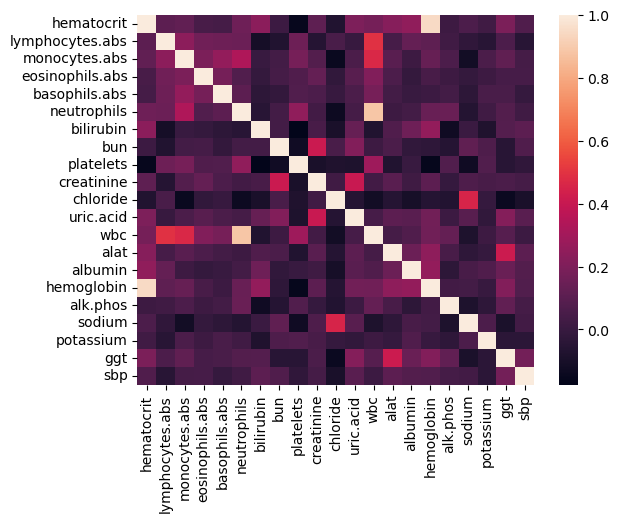

In [9]:
# Matriz de correlación utilizando la correlación de Spearman
corr_var_matrix, _ = spearmanr(final_data[variables]) 
var_labels = final_data[variables].columns

# Matriz de distancias
corrd_var_matrix = 1 - np.abs(corr_var_matrix) 

# Matriz de distancias condensadas,  Observe el heatmap y las correlaciones 
corrd_var_matrix_condense = squareform(corrd_var_matrix, checks = False) 
sns.heatmap(corr_var_matrix, xticklabels= var_labels, yticklabels= var_labels)  

### Observando el dendrograma

Primero una breve explicación del clustering aglomerativo jerárquico:

* Clustering: Porque nos permite formar grupos/clusters entre variables que sean similares enter sí.

* Aglomerativo: Porque cada variable empieza en su propio grupo y se va uniendo (aglomerando) con otros grupos.

* Jerárquico: Se pueden formar jerarquías en los grupos de acuerdo a la similitud/ distancia de los mismos, esto se observa en el eje Y del dendrograma

Existen diferentes formas de calcular esas distancias entre clusters, el método average (parametro de la función linkage) resulta el mas robusto (aunque computacionalmente es mas costoso)



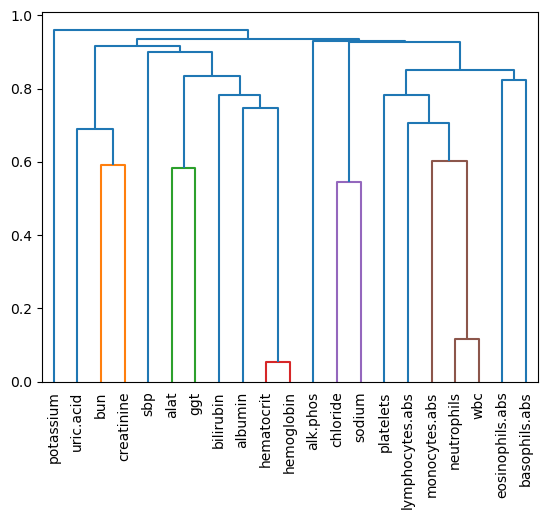

In [10]:
#Mergins contiene los clusters obtenidos y la distancias entre ellos; pero para observarlo utilizamos a dendrogram
mergings = linkage(corrd_var_matrix_condense, method = 'average')

#Es importante pasarle un array de labels para poder interpretar correctamente el gráfico
var_dendrogram = dendrogram(mergings, labels = var_labels, leaf_rotation = 90)

La función **dendrogram** acepta el objeto devuelto por linkage y las labels de cada variable para poder interpretarlo. Observese los clusters, por ejemplo el de hematocrito-hemoglobina o el del conteo de células blancas-neutrofilos como los mas similares; el cluster 'renal' se puede observar con el ácido úrico, bun y creatinina; así como el cluster 'hepático' con alat,ggt, albumina y bilirrubina. **Esto nos puede ayudar a reducir variables para posteriores análisis**.

Lo mismo se puede hacer con los efectos adversos!!!

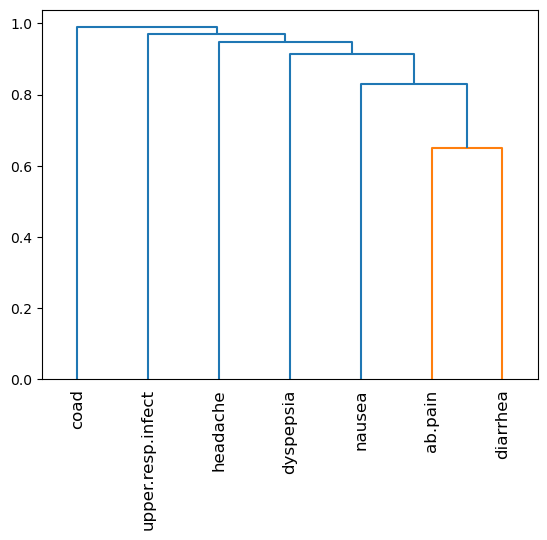

In [11]:
#Realizamos el mismo procedimiento pero ahora con efectos adversos
corr_ea_matrix, _ = spearmanr(final_data[efectos_adversos])
ea_labels = final_data[efectos_adversos].columns
corrd_ea_matrix = 1 - np.abs(corr_ea_matrix)
corrd_ea_matrix_condense = squareform(corrd_ea_matrix, checks = False)
mergings = linkage(corrd_ea_matrix_condense, method = 'average')
ea_dendrogram = dendrogram(mergings, labels = ea_labels, leaf_rotation = 90)

## Conclusión

* Se observa un cluster 'Gastrointestinal' de diarrhea, dolor abdominal y nausea; también se tiene que la enfermedad pulmonar obstructiva crónica  se presenta como un efecto adverso con escasa relación a los demás. Si a esto le sumamos que parece no tener relación con el tratamiento del medicamento, es probable que exista cierta predispocición de los pacientes reclutados a presentar esta enfermedad, bien sea por su edad, conmorbilidades etc...
  
* Es evidente que el número de pacientes es muy limitado para poder observar otros efectos adversos menos comunes, por ejemplo en el apartado anterior observamos que el grupo 'Drug' presentaba un mayor conteo plaquetario, esto es algo que se tuvo que tener en cuenta a la hora de hacer farmacovigilancia cuando el medicamento salió al mercado

* Se pueden hacer más análisis, por ejemplo si el efecto adverso es más frecuente en pacientes de cierto sexo o de cierta raza